# Assignment 3 - part 2
Lauri Pessi | bft860

## Dataset: beer.csv (https://www.kaggle.com/shenba/time-series-datasets?select=monthly-beer-production-in-austr.csv)

In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import acf

plt.style.use('seaborn-whitegrid')

In [85]:
# Fetch data
df = pd.read_csv('http://myy.haaga-helia.fi/~menetelmat/Data-analytiikka/Teaching/beer.csv') 
df.index = pd.to_datetime(df['Month'],format="%Y-%m") 
df = df.drop('Month',axis=1) 
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


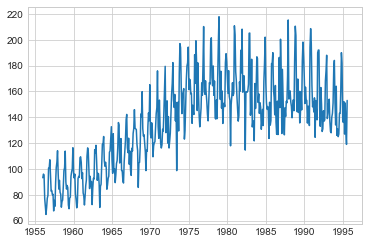

In [107]:
# Let's start by looking how the data looks like when plotted.
plt.plot(df);

## Initial assumptions
As expected the dataset seems to have both seasonal and trend elements, though the trend appears to follow some higher order function instead of being simply linear.
- My guess for the seasonality element is that production increases towards the summer.

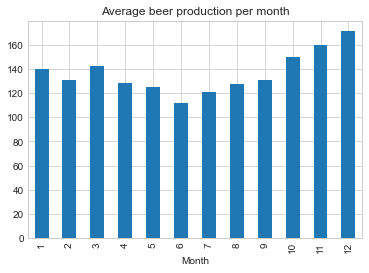

In [73]:
df['Monthly beer production'].groupby(df.index.month).mean().plot.bar(title='Average beer production per month');

Now one could be suprised that the production increases towards the end of the year, but there's an easy explanation.
Based on the original Kaggle-filename, measures are from Australia where the hottest season spans from December to February.

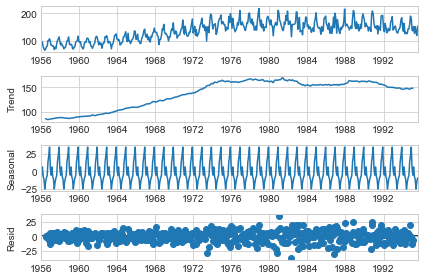

In [16]:
# Let's start by decomposing the seasonal, trend and noise elements of the series
comps = seasonal_decompose(df)

comps.plot(); # Semicolon-hack to fix duplicate output

## Forecasting

Highest autocorrelation at the lags of:


array([ 0, 12, 24])

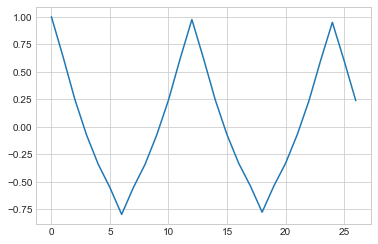

In [17]:
# While I'm quite sure of the seasonal trend being yearly, there's no harm in calculating autocorrelations from the seasonal element 
lags = acf(comps.seasonal)

plt.plot(lags)
print('Highest autocorrelation at the lags of:')
np.flip(np.argsort(lags))[0:3]

In [87]:
# And as expected, the seasonal element autocorrelates at lags of 0, 12 and 24 months. 
# Now I'm rather confident on using 12 for seasonal_periods.
# Frequency is set at MonthStart while trend and seasonal calculation methods were determined by guesswork.

model = ExponentialSmoothing(df['Monthly beer production']
                                , trend = 'add'
                                , seasonal = 'mul'
                                , freq='MS'
                                , seasonal_periods = 12).fit()

model.summary()

# I ended up trying different combinations for trend and seasonal methods, but the first was the best by lowest SSE

# add, mul SSE: 44043.492
# add, add SSE: 46639.295
# mul, add SSE: 46684.738
# mul, mul SSE: 44132.249

Dep. Variable:,Monthly beer production,No. Observations:,476
Model:,ExponentialSmoothing,SSE,44043.492
Optimized:,True,AIC,2187.097
Trend:,Additive,BIC,2253.744
Seasonal:,Multiplicative,AICC,2188.594
Seasonal Periods:,12,Date:,"Thu, 03 Mar 2022"
Box-Cox:,False,Time:,17:48:15
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0841412,alpha,True
smoothing_trend,0.0841412,beta,True


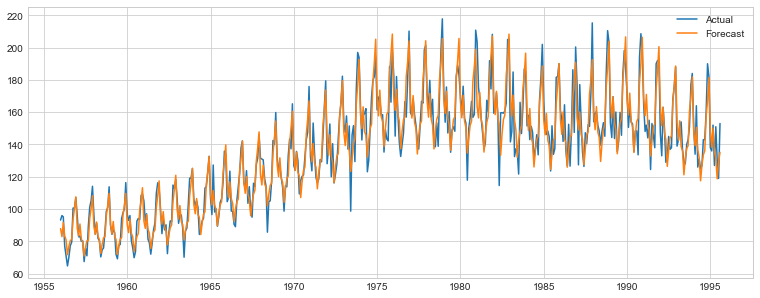

In [76]:
# Plot forecast on top of actuals
plt.figure(figsize=(13, 5))
df['Forecast'] = model.fittedvalues
plt.plot(df, label=['Actual', 'Forecast'])
plt.legend();

## Model performance assesment
Visually the prediction seems to track rather nicely both seasonal and trend elements
Let's take a look into residuals to elaborate this further.

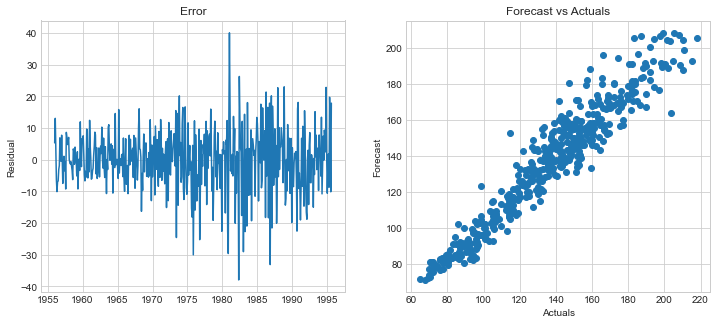

In [82]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(model.resid)
plt.ylabel('Residual')
plt.title('Error')


plt.subplot(1,2,2)
plt.scatter(x=df['Monthly beer production'], y=model.fittedvalues)
plt.title('Forecast vs Actuals')
plt.xlabel('Actuals')
plt.ylabel('Forecast');


### Residuals
Error rates spike at early 80'ties - when looking at the overlaid plots, it seems the model failed to capture some of the high and low peaks present in the actuals.

## A peek into the future

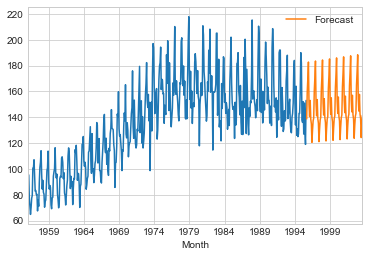

In [91]:
# Monthly index for upcoming 12 months
index = pd.date_range('1995-09-01', periods = 96, freq = 'MS')
beercast = model.forecast(96)

df2 = pd.DataFrame(data = beercast, index = index, columns=['Forecast'])

ax = df['Monthly beer production'].plot()
df2.plot(ax=ax);

## Final thoughts
While the prediction obviously has some idea, especially on the seasonal variation it obviously suffers quite a bit the longer it's extended.
It would be useful to see some measures of confidence, as the accuracy should detoriate heavily the further the forecast is extended.

As I didn't find how to draw confidence intervals, let's end this with a simulation instead.

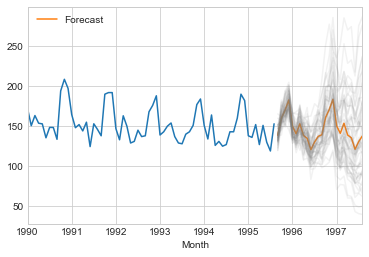

In [106]:
# Run 50 versions of 24 moths prediction and plot faintly on top of the previous forecast
simulations = model.simulate(24, repetitions=50, error="mul")

ax = df['Monthly beer production']['1990':].plot()
df2[:'1997-08-01'].plot(ax=ax);
simulations.plot(ax=ax, style="-", alpha=0.1, color="grey", legend=False);